# PyCPT Version 2

This is an example of a PyCPT Version 2 seasonal climate forecasting workflow. This notebook can be adapted to suit your exact needs through modifications of the code. This notebook uses PyCPT v2 utilities to 

1. download data from the IRI Data Library (through the CPT-DL python library) 
2. Run bias-correction using the IRI Climate Predictability Tool (through its companion python library, CPT-CORE) 
3. Plot skills scores and spatial loadings
4. Produce a multi-model ensemble forecast by taking the simple average of the bias-corrected members
5. Plots skill scores, deterministic forecasts, probabilistic forecasts, and exceedance probabilities for this NextGen MME forecast. 

PyCPT Version 2 was primarily designed and implemented by Kyle Hall

#### Imports - This cell imports PyCPTv2 libraries 

In [1]:
import cptdl as dl 
import cptio as cio 
import cptcore as cc 
import cptextras as ce 

import xarray as xr 
import datetime as dt 
from pathlib import Path 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import numpy as np

import cartopy.feature as cartopyFeature

In [2]:
# Query list of predictors and predictands available in IRI Data Library
#print([i for i in list(dl.hindcasts.keys()) if "PRCP" in i ])
print([i for i in list(dl.observations.keys()) if "PRCP" in i ])

['ENACTS-BANGLADESH.PRCP', 'ENACTS-COLOMBIA.PRCP', 'ENACTS-GAMBIA.PRCP', 'ENACTS-GUATEMALA.PRCP', 'ENACTS-ICPAC.PRCP', 'ENACTS-VIETNAM.PRCP', 'CHILESTATIONS.PRCP', 'UCSB.PRCP', 'UCSB0p05.PRCP', 'CPCCMAPURD.PRCP', 'TRMM.PRCP']


#### Define Case Directory

In [3]:
caseDir = "pycpt_WAfricaJAS_startJun"

#### Parameters - This cell defines the parameters of your analysis

In [4]:
case_directory = Path.home() / "Desktop/pycpt" / caseDir
case_directory.mkdir(exist_ok=True, parents=True)


MOS = 'CCA' # must be one of 'CCA', 'PCR', or "None"
predictor_names = ['CFSv2.PRCP','SEAS5.PRCP']
predictand_name = 'UCSB.PRCP'

# use dl.observations.keys() to see all options for predictand 
# and dl.hindcasts.keys() to see all options for predictors
# make sure your first_year & final_year are compatible with 
# your selections for your predictors and predictands 

download_args = { 
   # 'fdate':
   #   the initialization date of the model forecasts / hindcasts
   #   this field is defined by a python datetime.datetime object
   #   for example: dt.datetime(2022, 5, 1) # YYYY, MM, DD as integers
   #   The year field is only used for forecasts, otherwise ignored
   #   The day field is only used in subseasonal forecasts, otherwise ignored
   #   The month field is an integer representing a month - ie, May=5
  'fdate': dt.datetime(2022, 6, 1),  
    
   # 'first_year':
   #   the first year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**
   #   double check that your model has hindcast data for all years in [first_year, final_year]
   #   This field is defined by a python integer representing a year, ie: 1993
  'first_year': 1982, 
    
   # 'final_year':
   #   the final year of hindcasts you want. **NOT ALL MODELS HAVE ALL YEARS**
   #   double check that your model has hindcast data for all years in [first_year, final_year]
   #   This field is defined by a python integer representing a year, ie: 2016
  'final_year': 2016, 
    
   # 'predictor_extent':
   #   The geographic bounding box of the climate model data you want to download
   #   This field is defined by a python dictionary with the keys "north", "south",
   #   "east", and "west", each of which maps to a python integer representing the 
   #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
   #   "south" the southernmost boundary. Example: {"north": 90, "south": 90, "east": 0, "west": 180}
  'predictor_extent': {
    'east': 20,
    'west': -20, 
    'north': 20, 
    'south': 0
  }, 
    
   # 'predictand_extent':
   #   The geographic bounding box of the observation data you want to download
   #   This field is defined by a python dictionary with the keys "north", "south",
   #   "east", and "west", each of which maps to a python integer representing the 
   #   edge of a bounding box. i.e., "north" will be the northernmost boundary,
   #   "south" the southernmost boundary. Example: {"north": 90, "south": 90, "east": 0, "west": 180}
  'predictand_extent': {
    'east': 10,
    'west': -18, 
    'north': 18, 
    'south': 3
  }, 
    
   # 'lead_low': 
   #   the number of months from the first of the initialization month to the center of 
   #   the first month included in the target period. Always an integer + 0.5. 
   #   this field is defined by a python floating point number 
   #   for example  a lead-1 forecast would use lead_low=1.5, if you want init=may, target=Jun-..
  'lead_low': 1.5,
    
   # 'lead_high': 
   #   the number of months from the first of the initialization month to the center of 
   #   the last month included in the target period. Always an integer + 0.5. 
   #   this field is defined by a python floating point number 
   #   for example  a forecast initialized in may, whose target period ended in Aug, 
   #   would use lead_high=3.5
  'lead_high': 3.5, 
    
   # 'target': 
   #   Mmm-Mmm indicating the months included in the target period of the forecast. 
   #   this field is defined by a python string, with two three-letter month name abbreviations 
   #   whose first letters are capitalized, and all other letters are lowercase
   #   and who are separated by a dash character. 
   #   for example, if you wanted a JJA target period, you would use 'Jun-Aug'
  'target': 'Jul-Sep',
    
   # 'filetype':
   #   the filetype to be downloaded. for now, it saves a lot of headache just to set this equal
   #   to 'cptv10.tsv' which is a boutique plain-text CPT filetype based on .tsv + metadata
  'filetype': 'cptv10.tsv'
}

cpt_args = { 
    'transform_predictand': None,  # transformation to apply to the predictand dataset - None, 'Empirical', 'Gamma'
    'tailoring': None,  # tailoring None, 'Anomaly', 'StdAnomaly', or 'SPI' (SPI only available on Gamma)
    'cca_modes': (1,3), # minimum and maximum of allowed CCA modes 
    'x_eof_modes': (1,8), # minimum and maximum of allowed X Principal Componenets 
    'y_eof_modes': (1,6), # minimum and maximum of allowed Y Principal Components 
    'validation': 'crossvalidation', # the type of validation to use - crossvalidation, retroactive, or doublecrossvalidation
    'drymask': False, #whether or not to use a drymask of -999
    'scree': True, # whether or not to save % explained variance for eof modes
    'crossvalidation_window': 5,  # number of samples to leave out in each cross-validation step 
    'synchronous_predictors': True, # whether or not we are using 'synchronous predictors'
}


force_download = True

In [5]:
#extracting domain boundaries and create house keeping
domain = download_args['predictor_extent']
e,w,n,s = domain.values()

domainFolder = str(w)+"W-" + str(e)+"E" +'_to_'+ str(s)+"S-" + str(n)+"N"

domainDir = Path.home() / "Desktop" / caseDir / domainFolder
domainDir.mkdir(exist_ok=True, parents=True)

dataDir = Path.home() / "Desktop" / caseDir / domainFolder / "data"
dataDir.mkdir(exist_ok=True, parents=True)

figDir = Path.home() / "Desktop" / caseDir / domainFolder / "figures"
figDir.mkdir(exist_ok=True, parents=True)

outputDir = Path.home() / "Desktop" / caseDir / domainFolder / "output"
outputDir.mkdir(exist_ok=True, parents=True)

#print(dataDir)

In [6]:
# Uncomment the following line & change the config filepath to save this configuration: 
config_file = ce.save_configuration(caseDir+'.config', download_args, cpt_args, MOS, predictor_names, predictand_name )

# Uncomment the following line & change the config filepath to load an existing configuration: 
#MOS, download_args, cpt_args, predictor_names, predictand_name = ce.load_configuration('test1.config')

#### Download Observations

In [7]:
# Deal with "Cross-year issues" where either the target season crosses Jan 1 (eg DJF), 
# or where the forecast initialization is in the calendar year before the start of the target season
# (eg JFM from Dec 1 sart)

fmon=download_args['fdate'].month
tmon1 = fmon + download_args['lead_low'] # first month of the target season
tmon2 = fmon + download_args['lead_high'] # last month of the target season
download_args_obs = download_args.copy()


# For when the target season crossing Jan 1 (eg DJF)
# (i.e., when target season starts in the same calendar year as the forecast init 
# and ends in the following calendar year)
# Here the final year of the obs dataset needs to be incremented by 1.
if tmon1 <= 12.5 and tmon2 > 12.5:
    download_args_obs['final_year'] +=1    

# For JFM, FMA .. with forecast initialization in the previous year.
# (i.e., when target season starts in the calendar year after the forecast init.)
# Here both the first and final year of the obs dataset need to be incremented by 1.
if tmon1 > 12.5: 
    download_args_obs['first_year'] +=1
    download_args_obs['final_year'] +=1 
    
print(download_args) 
print(download_args_obs)

if not Path(dataDir / '{}.nc'.format(predictand_name)).is_file() or force_download:
    Y = dl.download(dl.observations[predictand_name], dataDir / (predictand_name +'.tsv'), **download_args_obs, verbose=True, use_dlauth=False)
    Y = getattr(Y, [i for i in Y.data_vars][0])
    Y.to_netcdf(dataDir / '{}.nc'.format(predictand_name))
else:
    Y = xr.open_dataset(dataDir / '{}.nc'.format(predictand_name))
    Y = getattr(Y, [i for i in Y.data_vars][0])

{'fdate': datetime.datetime(2022, 6, 1, 0, 0), 'first_year': 1982, 'final_year': 2016, 'predictor_extent': {'east': 20, 'west': -20, 'north': 20, 'south': 0}, 'predictand_extent': {'east': 10, 'west': -18, 'north': 18, 'south': 3}, 'lead_low': 1.5, 'lead_high': 3.5, 'target': 'Jul-Sep', 'filetype': 'cptv10.tsv'}
{'fdate': datetime.datetime(2022, 6, 1, 0, 0), 'first_year': 1982, 'final_year': 2016, 'predictor_extent': {'east': 20, 'west': -20, 'north': 20, 'south': 0}, 'predictand_extent': {'east': 10, 'west': -18, 'north': 18, 'south': 3}, 'lead_low': 1.5, 'lead_high': 3.5, 'target': 'Jul-Sep', 'filetype': 'cptv10.tsv'}
URL: https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/92/mul/T/(1%20Jan%201982)/(31%20Dec%202016)/RANGE/T/%28Jul-Sep%201982-2016%29/seasonalAverage/Y/%283%29/%2818%29/RANGEEDGES/X/%28-18%29/%2810%29/RANGEEDGES/-999/setmissing_value/%5BX/Y%5D%5BT%5Dcptv10.tsv

DOWNLOADING: [*************************] (3374 KB) 0:00:38.826167

#### Download Hindcast Data

In [8]:
# download training data 
hindcast_data = []
for model in predictor_names: 
    if not Path(dataDir / (model + '.nc')).is_file() or force_download:
        X = dl.download(dl.hindcasts[model],dataDir / ( model+'.tsv'), **download_args, verbose=True, use_dlauth=False)
        X = getattr(X, [i for i in X.data_vars][0])
        X.name = Y.name
        X.to_netcdf(dataDir / '{}.nc'.format(model))
    else:
        X = xr.open_dataset(dataDir / (model + '.nc'))
        X = getattr(X, [i for i in X.data_vars][0])
        X.name = Y.name
    hindcast_data.append(X)

URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES_FULL/.prec/S/%280000%201%20Jun%201982-2016%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/0/20/RANGEEDGES/X/-20/20/RANGEEDGES/%5BM%5D/average/92/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (446 KB) 0:00:09.071739
URL: https://iridl.ldeo.columbia.edu/SOURCES/.EU/.Copernicus/.CDS/.C3S/.ECMWF/.SEAS5/.hindcast/.prcp/S/%280000%201%20Jun%201982-2016%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/0/20/RANGEEDGES/X/-20/20/RANGEEDGES/%5BM%5D/average/c%3A/1000/(mm%20m-1)/%3Ac/mul/c%3A/86400/(s%20day-1)/%3Ac/mul/c%3A/92//units/(days)/def/%3Ac/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (446 KB) 0:00:07.236037


#### Download Forecast Data

In [9]:
# download forecast data 
forecast_data = []
for model in predictor_names: 
    if not Path(dataDir / (model + '_f.nc')).is_file() or force_download:
        F = dl.download(dl.forecasts[model], dataDir / (model+'_f.tsv'), **download_args, verbose=True, use_dlauth=False)
        F = getattr(F, [i for i in F.data_vars][0])
        F.name = Y.name
        F.to_netcdf(dataDir / (model + '_f.nc'))
    else:
        F = xr.open_dataset(dataDir / (model + '_f.nc'))
        F = getattr(F, [i for i in F.data_vars][0])
        F.name = Y.name
    forecast_data.append(F)

URL: https://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.HINDCAST/.PENTAD_SAMPLES_FULL/.prec/S/%280000%201%20Jun%202022%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/0/20/RANGEEDGES/X/-20/20/RANGEEDGES/%5BM%5D/average/92/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (13 KB) 0:00:00.514032
URL: https://iridl.ldeo.columbia.edu/SOURCES/.EU/.Copernicus/.CDS/.C3S/.ECMWF/.SEAS5/.forecast/.prcp/S/%280000%201%20Jun%202022%29/VALUES/L/1.5/3.5/RANGEEDGES/%5BL%5D//keepgrids/average/Y/0/20/RANGEEDGES/X/-20/20/RANGEEDGES/%5BM%5D/average/c%3A/1000/(mm%20m-1)/%3Ac/mul/c%3A/86400/(s%20day-1)/%3Ac/mul/c%3A/92//units/(days)/def/%3Ac/mul/-999/setmissing_value/%5BX/Y%5D%5BL/S/add%5D/cptv10.tsv

DOWNLOADING: [*************************] (14 KB) 0:00:00.378243


#### Perform Analysis 

In [10]:
hcsts, fcsts, skill, pxs, pys = [], [], [], [], []

for i, model_hcst in enumerate(hindcast_data):
    
    
    if str(MOS).upper() == 'CCA':
        
        # fit CCA model between X & Y and produce real-time forecasts for F 
        cca_h, cca_rtf, cca_s, cca_px, cca_py = cc.canonical_correlation_analysis(model_hcst, Y, \
        F=forecast_data[i], **cpt_args, cpt_kwargs={"interactive": False})

#         fit CCA model again between X & Y, and produce in-sample probabilistic hindcasts 
#         this is using X in place of F, with the year coordinates changed to n+100 years
#         because CPT does not allow you to make forecasts for in-sample data
        cca_h, cca_f, cca_s, cca_px, cca_py = cc.canonical_correlation_analysis(model_hcst, Y, \
        F=ce.redate(model_hcst, yeardelta=48), **cpt_args)
        cca_h = xr.merge([cca_h, ce.redate(cca_f.probabilistic, yeardelta=-48), ce.redate(cca_f.prediction_error_variance, yeardelta=-48)])
        
#         # use the in-sample probabilistic hindcasts to perform probabilistic forecast verification
#         # warning - this produces unrealistically optimistic values 
        cca_pfv = cc.probabilistic_forecast_verification(cca_h.probabilistic, Y, **cpt_args)
        cca_s = xr.merge([cca_s, cca_pfv])

        hcsts.append(cca_h)
        fcsts.append(cca_rtf)
        skill.append(cca_s.where(cca_s > -999, other=np.nan))
        pxs.append(cca_px)
        pys.append(cca_py)
        
    elif str(MOS).upper() == 'PCR':
        
        # fit PCR model between X & Y and produce real-time forecasts for F 
        pcr_h, pcr_rtf, pcr_s, pcr_px = cc.principal_components_regression(model_hcst, Y, F=forecast_data[i], **cpt_args)
        
        # fit PCR model again between X & Y, and produce in-sample probabilistic hindcasts 
        # this is using X in place of F, with the year coordinates changed to n+100 years
        # because CPT does not allow you to make forecasts for in-sample data
        pcr_h, pcr_f, pcr_s, pcr_px = cc.principal_components_regression(model_hcst, Y, F=ce.redate(model_hcst, yeardelta=48), **cpt_args)
        pcr_h = xr.merge([pcr_h, ce.redate(pcr_f.probabilistic, yeardelta=-48), ce.redate(pcr_f.prediction_error_variance, yeardelta=-48)])
        
        # use the in-sample probabilistic hindcasts to perform probabilistic forecast verification
        # warning - this produces unrealistically optimistic values 
        pcr_pfv = cc.probabilistic_forecast_verification(pcr_h.probabilistic, Y, **cpt_args)
        pcr_s = xr.merge([pcr_s, pcr_pfv])
        hcsts.append(pcr_h)
        fcsts.append(pcr_rtf)
        skill.append(pcr_s.where(pcr_s > -999, other=np.nan))
        pxs.append(pcr_px)
    else:
        # simply compute deterministic skill scores of non-corrected ensemble means 
        nomos_skill = cc.deterministic_skill(model_hcst, Y, **cpt_args)
        skill.append(nomos_skill.where(nomos_skill > -999, other=np.nan))
        
    # choose what data to export here (any of the above results data arrays can be saved to netcdf)
    if str(MOS).upper() == 'CCA':
        cca_h.to_netcdf(outputDir /  (predictor_names[i] + '_crossvalidated_cca_hindcasts.nc'))
        cca_rtf.to_netcdf(outputDir / (predictor_names[i] + '_realtime_cca_forecasts.nc'))
        cca_s.to_netcdf(outputDir / (predictor_names[i] + '_skillscores_cca.nc'))
        cca_px.to_netcdf(outputDir / (predictor_names[i] + '_cca_x_spatial_loadings.nc'))
        cca_py.to_netcdf(outputDir / (predictor_names[i] + '_cca_y_spatial_loadings.nc'))
    elif str(MOS).upper() == 'PCR':
        pcr_h.to_netcdf(outputDir /  (predictor_names[i] + '_crossvalidated_pcr_hindcasts.nc'))
        pcr_rtf.to_netcdf(outputDir / (predictor_names[i] + '_realtime_pcr_forecasts.nc'))
        pcr_s.to_netcdf(outputDir / (predictor_names[i] + '_skillscores_pcr.nc'))
        pcr_px.to_netcdf(outputDir / (predictor_names[i] + '_pcr_x_spatial_loadings.nc'))
    else: 
        nomos_skill.to_netcdf(outputDircase_directory / (predictor_names[i] + '_nomos_skillscores.nc'))
        
    

In [11]:
# EOF explained variances are here
#cca_py.y_explained_variance
#pcr_px

#### Plot skill 

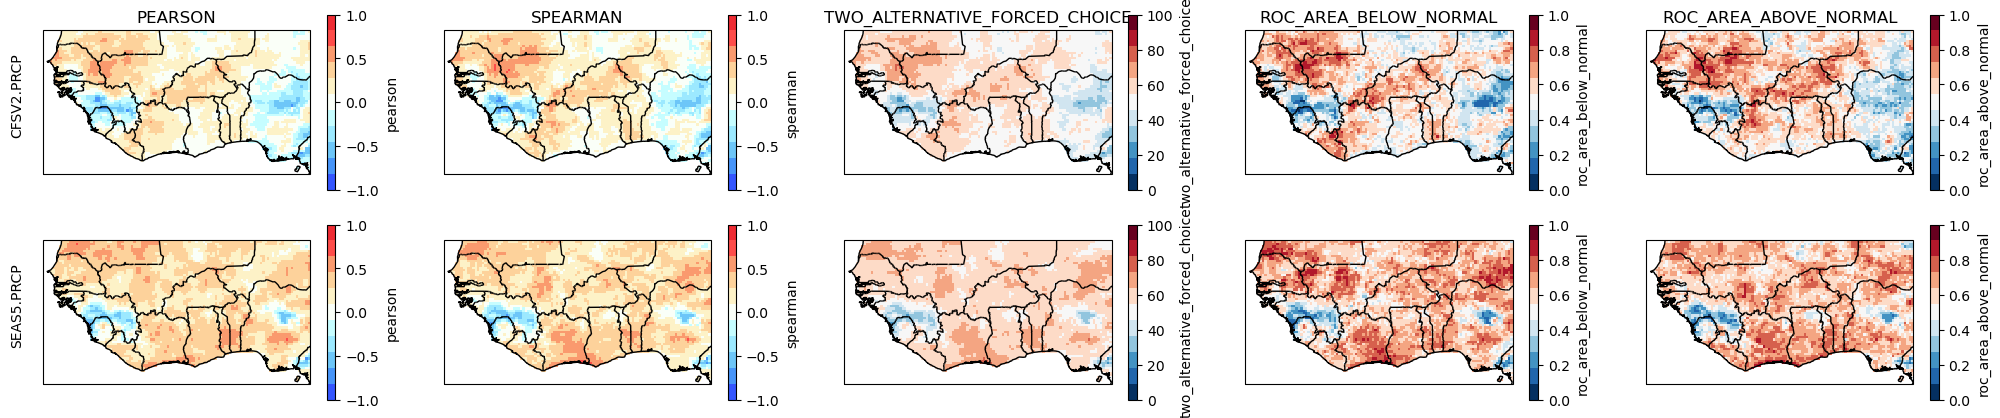

In [12]:
#skill_metrics = ['pearson', 'spearman', 'generalized_roc', 'rank_probability_skill_score']
# determnistic skill metrics: 'pearson', 'spearman', 'two_alternative_forced_choice', 'roc_area_under_curve', 'roc_area_above_curve'
# roc_area_under_curve = ROC Below Normal category
# roc_area_above_curve = ROC Above Normal category
# probabilistic skill metrics (in sample): 'generalized_roc', 'ignorance', 'rank_probability_skill_score'

#cmaps = [plt.get_cmap('cpt.correlation', 11), plt.get_cmap('cpt.correlation', 11), plt.get_cmap('RdBu_r', 11), plt.get_cmap('cpt.correlation', 11) ]
#limits = [(-1, 1), (-1, 1), (0, 100), (-50, 50)]

# deterministic five:
skill_metrics = ['pearson', 'spearman', 'two_alternative_forced_choice', 'roc_area_below_normal', 'roc_area_above_normal']
cmaps = [plt.get_cmap('cpt.correlation', 11), plt.get_cmap('cpt.correlation', 11), plt.get_cmap('RdBu_r', 11), plt.get_cmap('RdBu_r', 11), plt.get_cmap('RdBu_r', 11)]
limits = [(-1, 1), (-1, 1), (0, 100), (0,1), (0,1)]

missing_value_flag = -999

fig, ax = plt.subplots(nrows=len(predictor_names), ncols=len(skill_metrics), subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(5*len(skill_metrics), 2.5*len(predictor_names)))
if len(predictor_names) == 1: 
    ax = [ax]

for i, model in enumerate(predictor_names):
    for j, skill_metric in enumerate(skill_metrics):
        n = getattr(skill[i], skill_metric).where(getattr(skill[i], skill_metric) > missing_value_flag).plot(ax=ax[i][j], cmap=cmaps[j], vmin=limits[j][0], vmax=limits[j][1])
        ax[i][j].coastlines()
        ax[i][j].add_feature(cartopyFeature.BORDERS)
        ax[0][j].set_title(skill_metric.upper())

    ax[i][0].text(-0.07, 0.55, model.upper(), va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', transform=ax[i][0].transAxes)

# save plots    
figName = MOS + '_models_skillMatrices.png'
fig.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')    

#### Plot CCA Modes

CFSV2.PRCP: CCA MODE 1 - Canonical Correlation = 0.6977544992690001


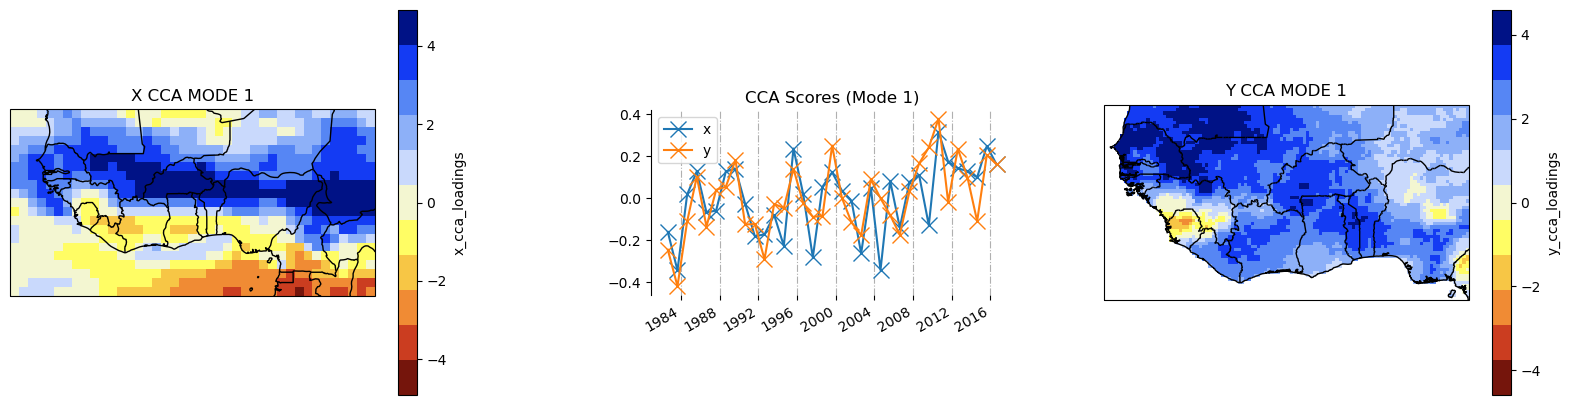

CFSV2.PRCP: CCA MODE 2 - Canonical Correlation = 0.4937841545419999


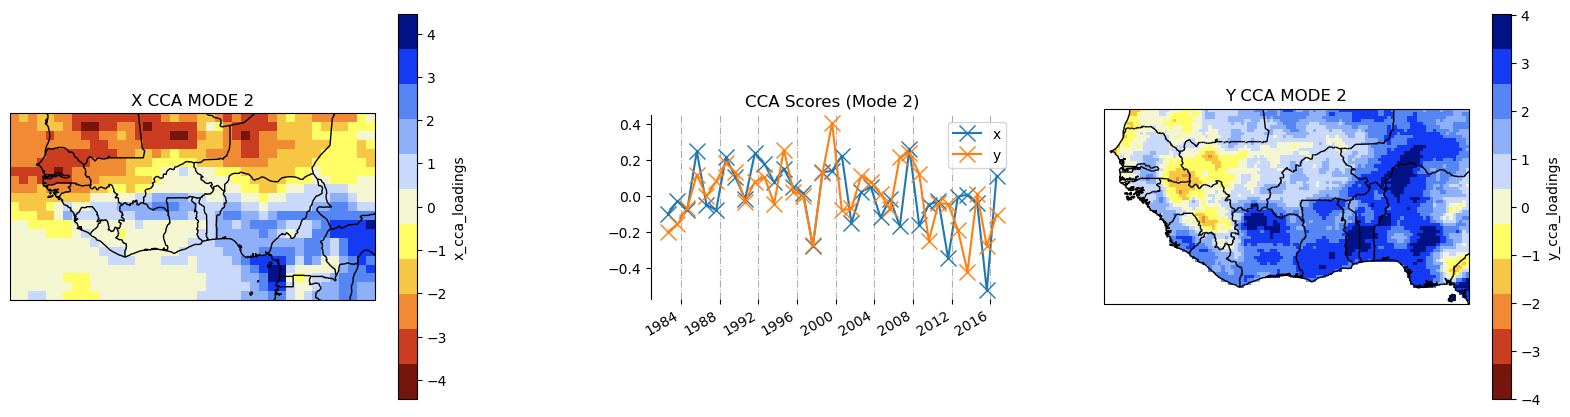

CFSV2.PRCP: CCA MODE 3 - Canonical Correlation = 0.24795061180300002


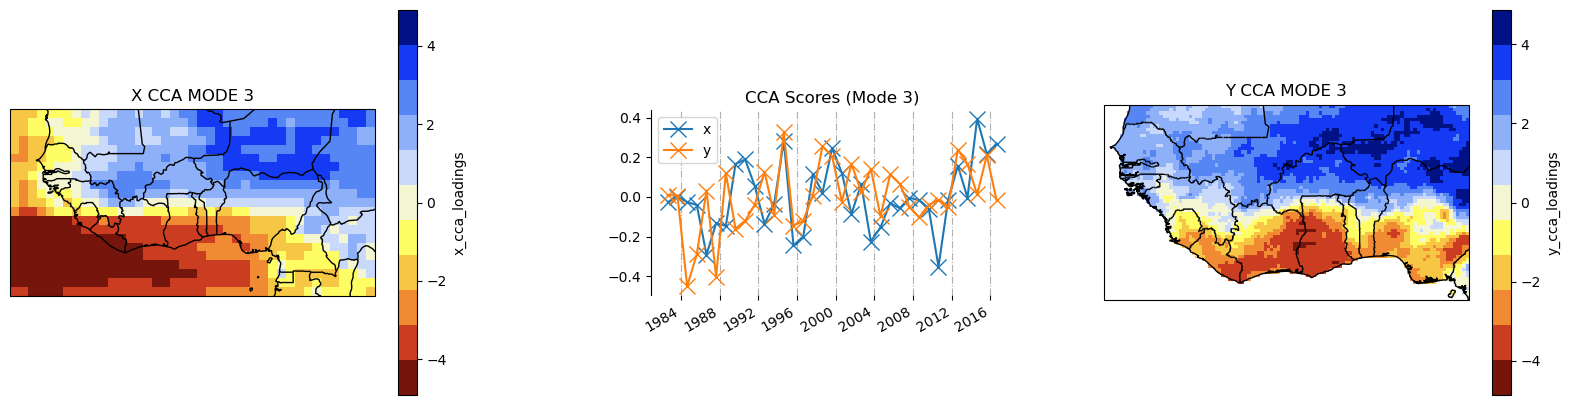

SEAS5.PRCP: CCA MODE 1 - Canonical Correlation = 0.726645270957


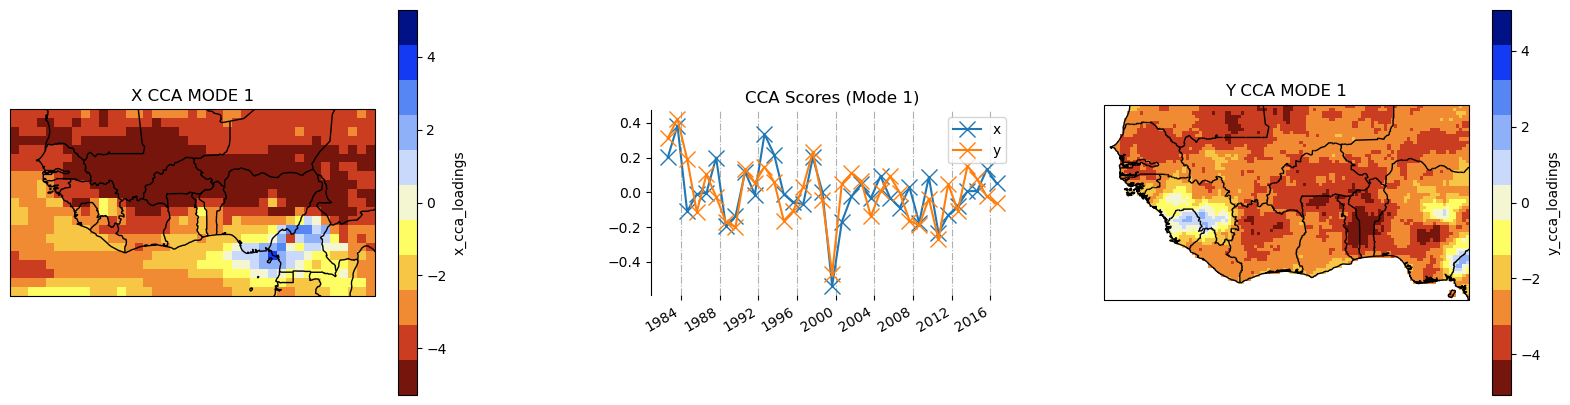

SEAS5.PRCP: CCA MODE 2 - Canonical Correlation = 0.5005924746429999


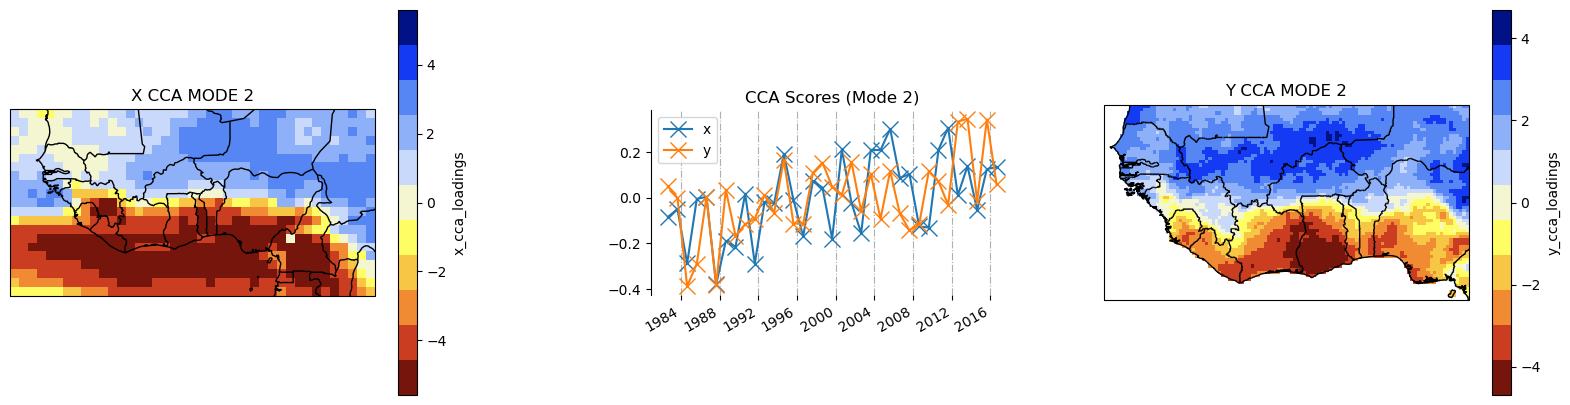

SEAS5.PRCP: CCA MODE 3 - Canonical Correlation = nan


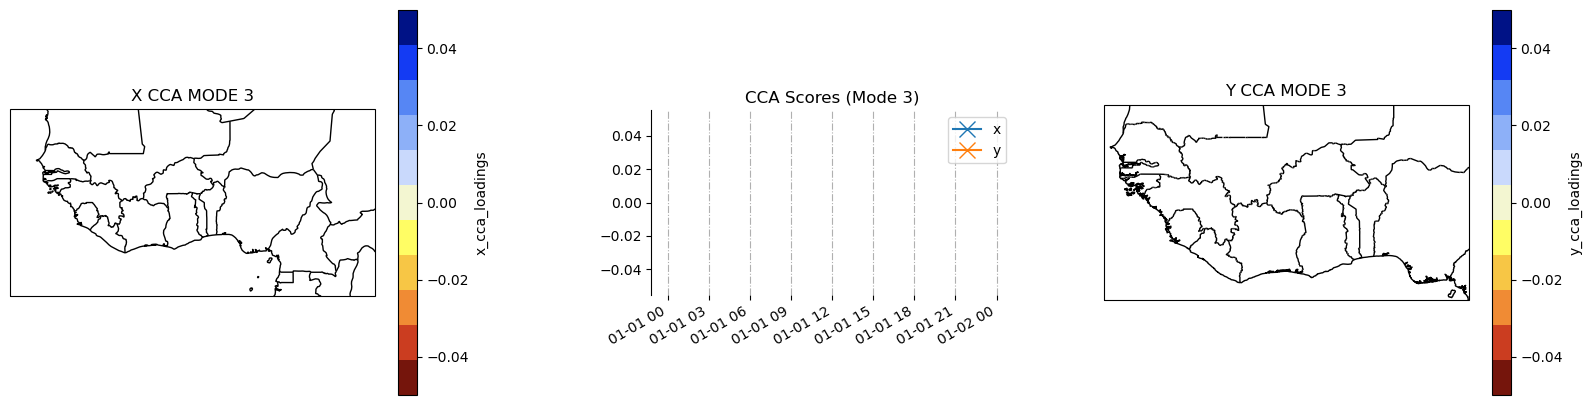

In [13]:
nmodes = 3
cmap= plt.get_cmap('cpt.loadings', 11)
vmin=-10
vmax = 10
missing_value_flag = -999

import matplotlib.gridspec as gridspec
if MOS == 'CCA':
    for i, model in enumerate(predictor_names):
        for mode in range(nmodes):
            cancorr = np.correlate(pxs[i].x_cca_scores[:,mode],pys[i].y_cca_scores[:,mode])
            print(model.upper() + ': CCA MODE {}'.format(mode+1) + ' - Canonical Correlation = ' + str(cancorr[0]))
            #print(model.upper() + ' - MODE {}'.format(mode+1))

            fig = plt.figure(figsize=(20,5))
            gs0 = gridspec.GridSpec(1, 3, figure=fig)
            gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])
            gs01 = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0[1])
            gs02 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[2])
            ts = xr.concat([pxs[i].x_cca_scores.isel(Mode=mode), pys[i].y_cca_scores.isel(Mode=mode)], 'M').assign_coords({'M': ['x', 'y']})
            
            map1_ax = fig.add_subplot(gs00[:,:], projection = ccrs.PlateCarree())
            ts_ax = fig.add_subplot( gs01[1:3,1:])
            map2_ax = fig.add_subplot(gs02[:,:], projection = ccrs.PlateCarree())
            
            pxs[i].x_cca_loadings.isel(Mode=mode).where(pxs[i].x_cca_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map1_ax, cmap=cmap)
            pys[i].y_cca_loadings.isel(Mode=mode).where(pys[i].y_cca_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map2_ax, cmap=cmap)

            primitive = ts.plot.line(marker='x', ax=ts_ax, markersize=12, hue='M', add_legend=False)
            ts_ax.grid(axis = 'x', linestyle = '-.')
            ts_ax.legend(handles=primitive, labels = list(ts.coords['M'].values), loc='best')
            ts_ax.spines['top'].set_visible(False)
            ts_ax.spines['right'].set_visible(False)
            ts_ax.spines['bottom'].set_visible(False)
            ts_ax.set_title('CCA Scores (Mode {})'.format(mode+1))
            ts_ax.set_ylabel(None)
            ts_ax.set_xlabel(None)
            
            map1_ax.set_title('X CCA MODE {}'.format(mode+1))
            map2_ax.set_title('Y CCA MODE {}'.format(mode+1))
            
            map1_ax.coastlines()
            map2_ax.coastlines()
            map1_ax.add_feature(cartopyFeature.BORDERS)
            map2_ax.add_feature(cartopyFeature.BORDERS)
            plt.show()              
               
            # save plots
            figName = MOS +'_'+ str(model) +'_CCA_mode_' + str(mode + 1) + '.png'
            fig.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')
else:
    print('You will need to set MOS=CCA in order to see CCA Modes')
        


#### Plot EOF Modes

CFSV2.PRCP: EOF 1


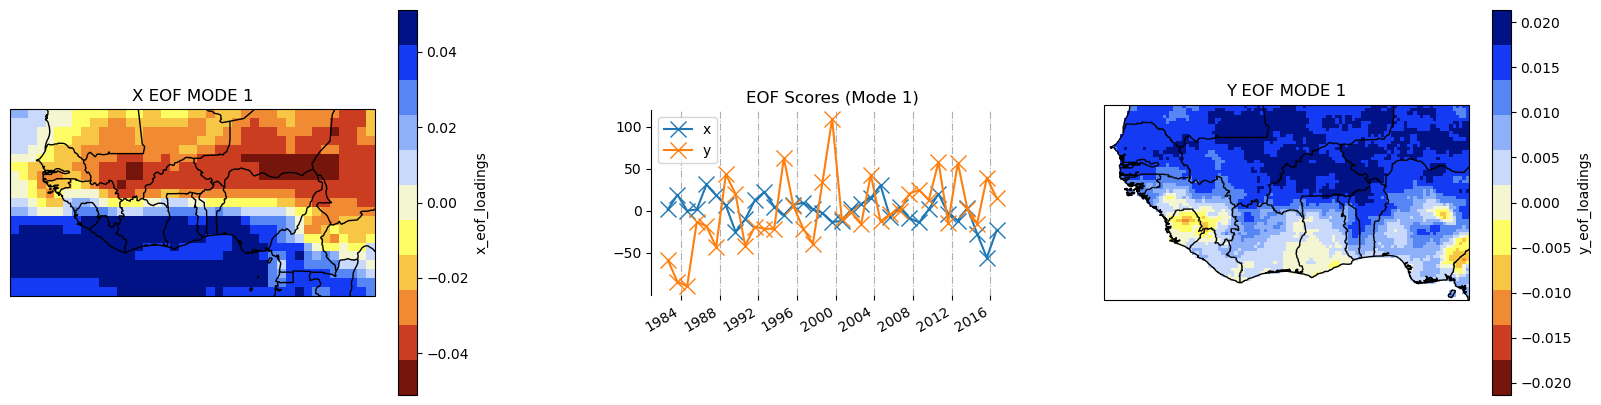

CFSV2.PRCP: EOF 2


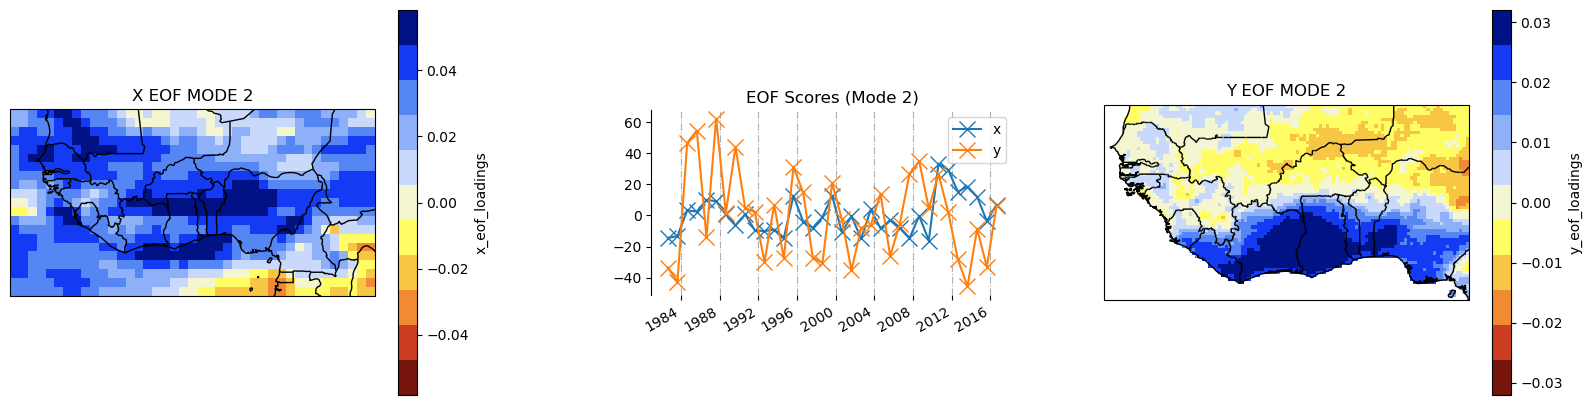

CFSV2.PRCP: EOF 3


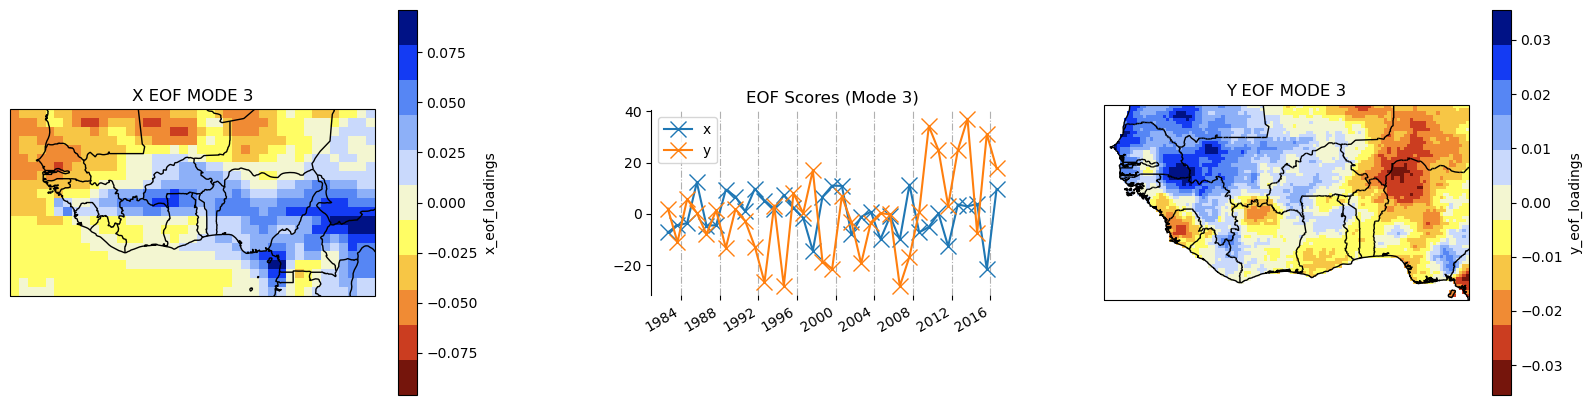

CFSV2.PRCP: EOF 4


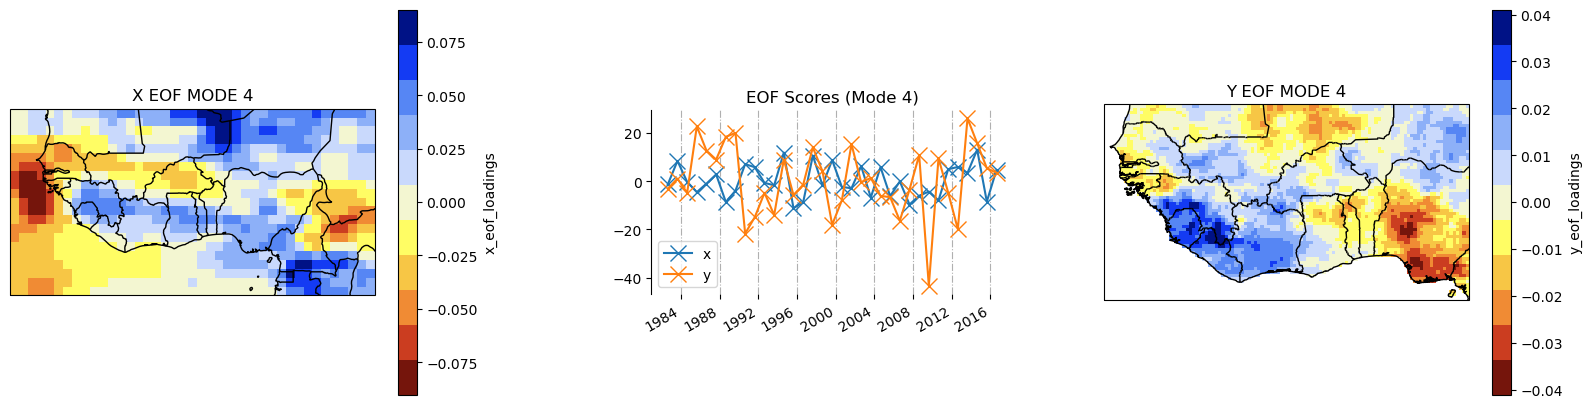

CFSV2.PRCP: EOF 5


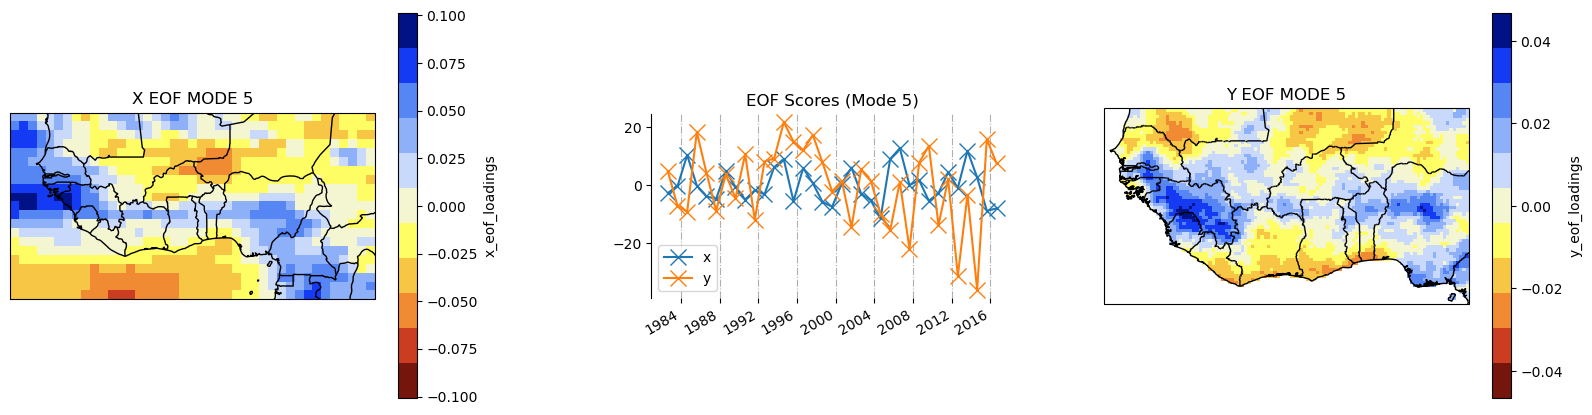

SEAS5.PRCP: EOF 1


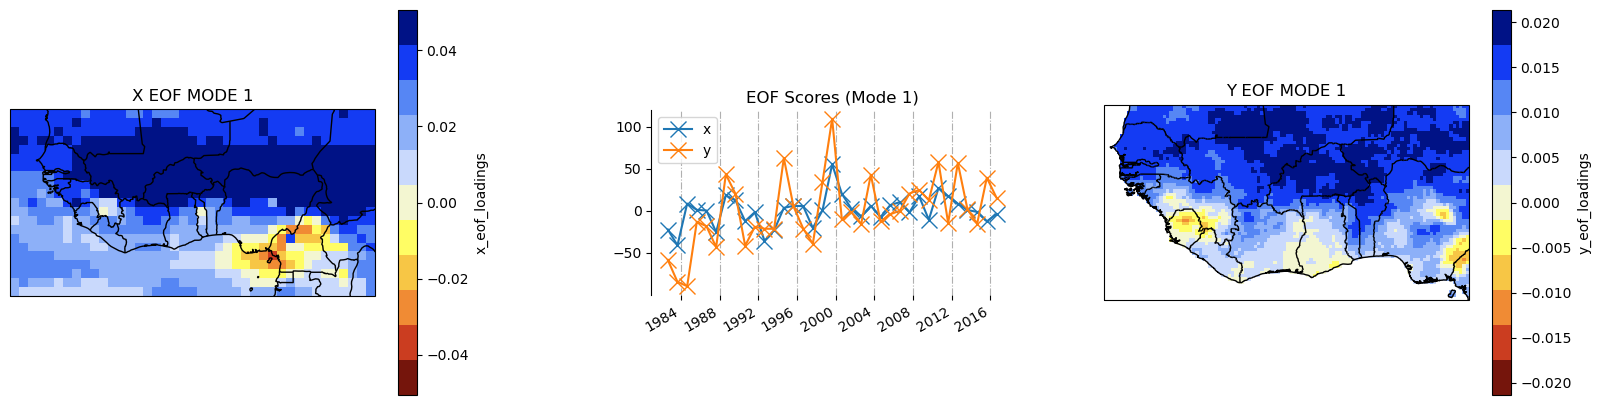

SEAS5.PRCP: EOF 2


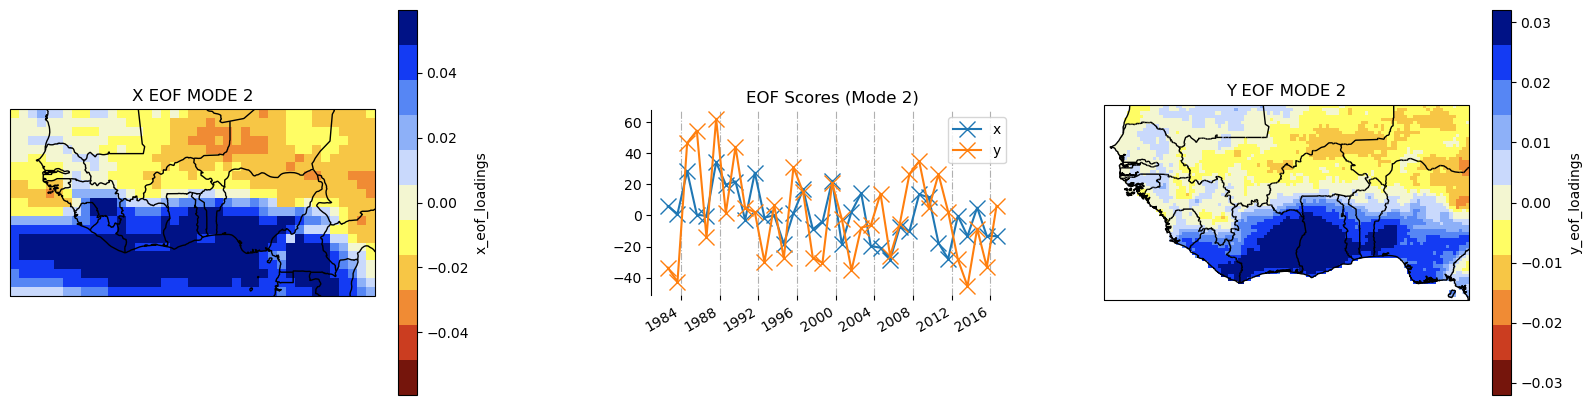

SEAS5.PRCP: EOF 3


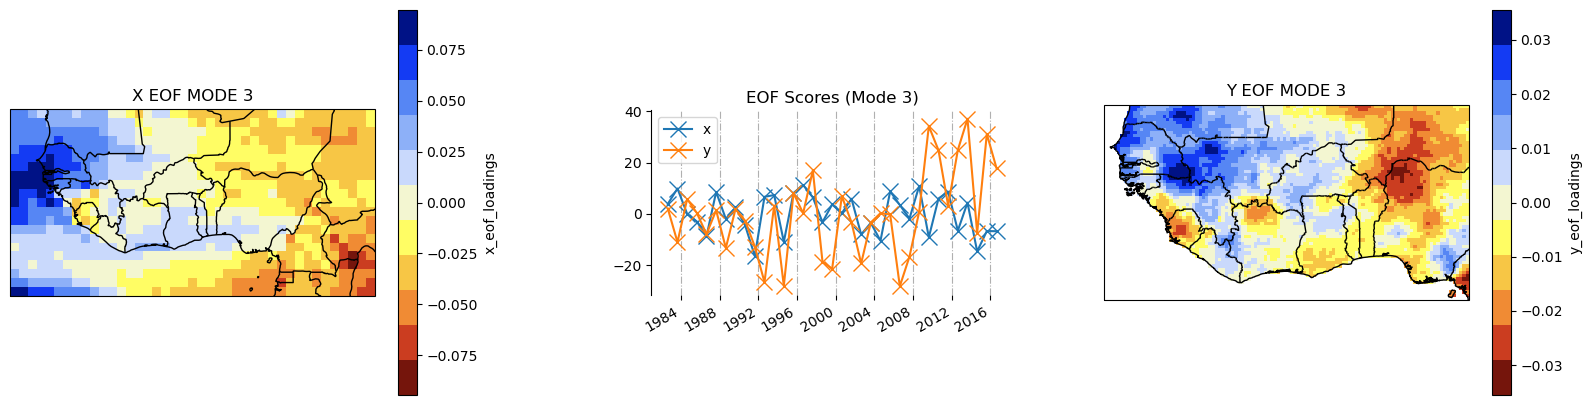

SEAS5.PRCP: EOF 4


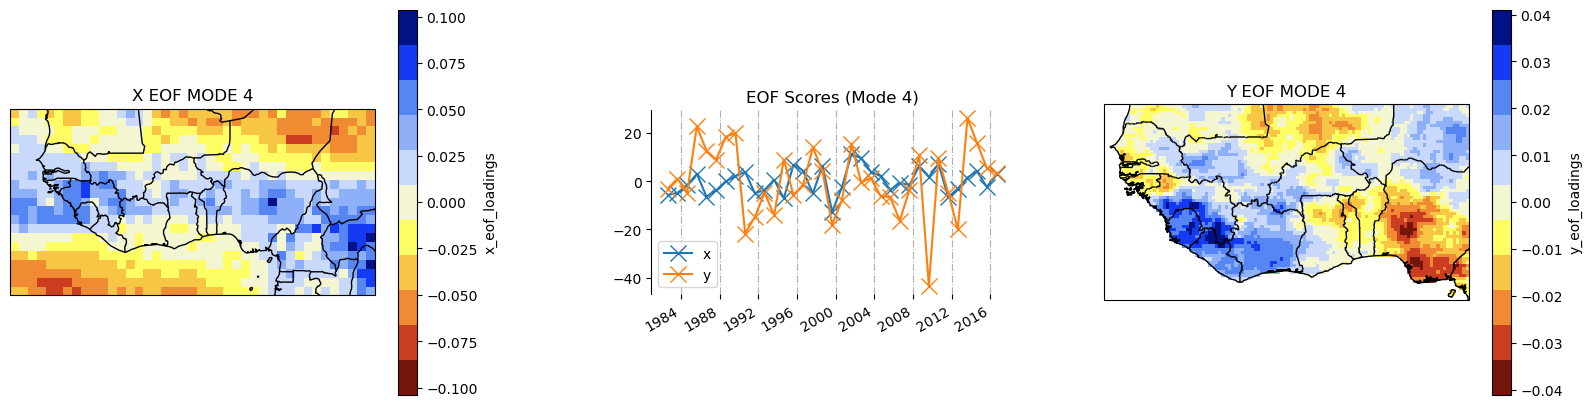

SEAS5.PRCP: EOF 5


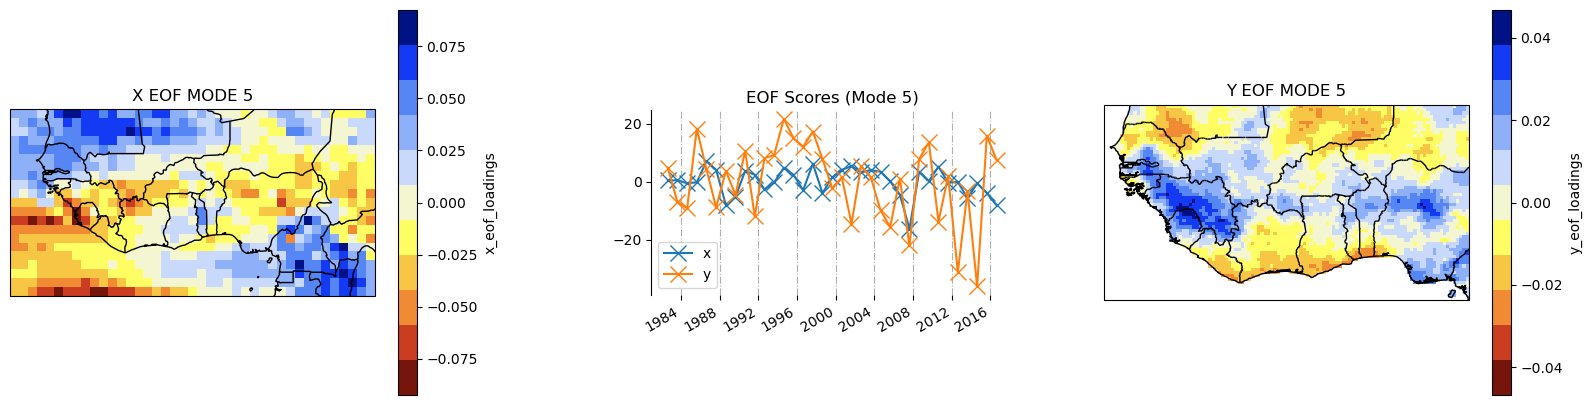

In [14]:
nmodes = 5
cmap= plt.get_cmap('cpt.loadings', 11)
vmin=-10
vmax = 10

import matplotlib.gridspec as gridspec
if MOS == 'CCA':
    for i, model in enumerate(predictor_names):
        for mode in range(nmodes):
            print(model.upper() + ': EOF {}'.format(mode+1))
            fig = plt.figure(figsize=(20,5))
            gs0 = gridspec.GridSpec(1, 3, figure=fig)
            gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])
            gs01 = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0[1])
            gs02 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[2])
            ts = xr.concat([pxs[i].x_eof_scores.isel(Mode=mode), pys[i].y_eof_scores.isel(Mode=mode)], 'M').assign_coords({'M': ['x', 'y']})
            
            map1_ax = fig.add_subplot(gs00[:,:], projection = ccrs.PlateCarree())
            ts_ax = fig.add_subplot( gs01[1:3,1:])
            map2_ax = fig.add_subplot(gs02[:,:], projection = ccrs.PlateCarree())
            
            pxs[i].x_eof_loadings.isel(Mode=mode).where(pxs[i].x_eof_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map1_ax, cmap=cmap)
            pys[i].y_eof_loadings.isel(Mode=mode).where(pys[i].y_eof_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map2_ax, cmap=cmap)

            primitive = ts.plot.line(marker='x', ax=ts_ax, markersize=12, hue='M', add_legend=False)
            ts_ax.grid(axis = 'x', linestyle = '-.')
            ts_ax.legend(handles=primitive, labels = list(ts.coords['M'].values), loc='best')
            ts_ax.spines['top'].set_visible(False)
            ts_ax.spines['right'].set_visible(False)
            ts_ax.spines['bottom'].set_visible(False)
            ts_ax.set_title('EOF Scores (Mode {})'.format(mode+1))
            ts_ax.set_ylabel(None)
            ts_ax.set_xlabel(None)
            
            map1_ax.set_title('X EOF MODE {}'.format(mode+1))
            map2_ax.set_title('Y EOF MODE {}'.format(mode+1))
            
            map1_ax.coastlines()
            map2_ax.coastlines()
            map1_ax.add_feature(cartopyFeature.BORDERS)
            map2_ax.add_feature(cartopyFeature.BORDERS)
            plt.show()
            
            # save plots
            figName = MOS +'_'+ str(model) +'_EOF_mode_' + str(mode + 1) + '.png'
            fig.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight') 
elif MOS == 'PCR':
    for i, model in enumerate(predictor_names):
        for mode in range(nmodes):
            print(model.upper() + ' - MODE {}'.format(mode+1))
            fig = plt.figure(figsize=(20,5))
            gs0 = gridspec.GridSpec(1, 3, figure=fig)
            gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])
            gs01 = gridspec.GridSpecFromSubplotSpec(4, 5, subplot_spec=gs0[1])
            gs02 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[2])
            ts = xr.concat([pxs[i].x_eof_scores.isel(Mode=mode)], 'M').assign_coords({'M': ['x']})
            
            map1_ax = fig.add_subplot(gs00[:,:], projection = ccrs.PlateCarree())
            ts_ax = fig.add_subplot( gs01[1:3,1:])
            map2_ax = fig.add_subplot(gs02[:,:], projection = ccrs.PlateCarree())
            
            pxs[i].x_eof_loadings.isel(Mode=mode).where(pxs[i].x_eof_loadings.isel(Mode=mode) > missing_value_flag).plot(ax=map1_ax, cmap=cmap)            #pys[i].y_eof_loadings.isel(Mode=mode).plot(ax=map2_ax, cmap=cmap)

            primitive = ts.plot.line(marker='x', ax=ts_ax, markersize=12, hue='M', add_legend=False)
            ts_ax.grid(axis = 'x', linestyle = '-.')
            ts_ax.legend(handles=primitive, labels = list(ts.coords['M'].values), loc='best')
            ts_ax.spines['top'].set_visible(False)
            ts_ax.spines['right'].set_visible(False)
            ts_ax.spines['bottom'].set_visible(False)
            ts_ax.set_title('EOF Scores (Mode {})'.format(mode+1))
            ts_ax.set_ylabel(None)
            ts_ax.set_xlabel(None)
            
            map1_ax.set_title('X EOF MODE {}'.format(mode+1))
            #map2_ax.set_title('Y EOF MODE {}'.format(mode+1))
            
            map1_ax.coastlines()
            map1_ax.add_feature(cartopyFeature.BORDERS)
            #map2_ax.coastlines()
            plt.show()
            
            # save plots
            figName = MOS +'_'+ str(model) +'_EOF_mode_' + str(mode + 1) + '.png'
            fig.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')
else:
    print('You will need to set MOS=CCA in order to see CCA Modes')

#### Plot Forecasts

CFSV2.PRCP


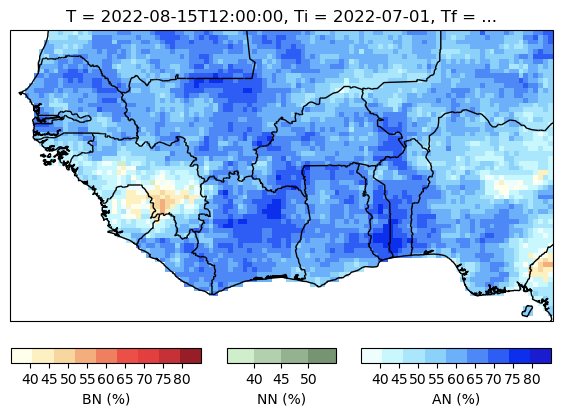

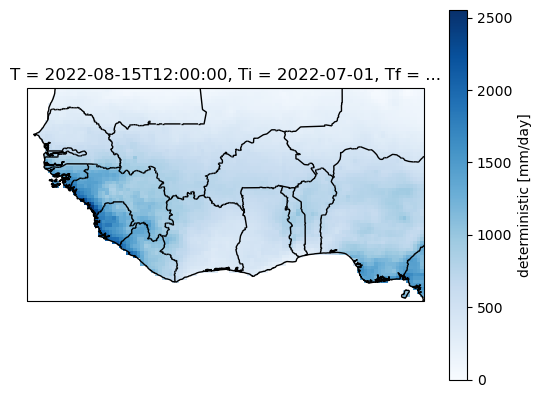

SEAS5.PRCP


<Figure size 640x480 with 0 Axes>

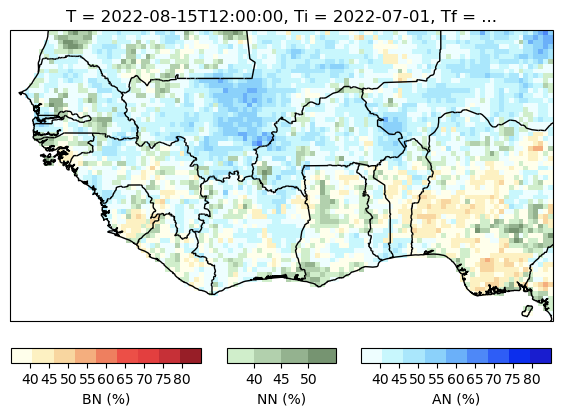

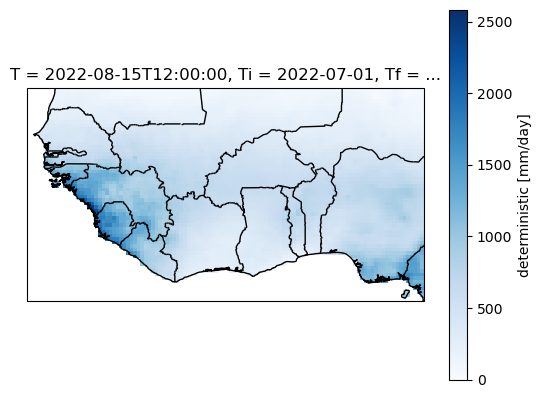

<Figure size 640x480 with 0 Axes>

In [15]:
cmap= plt.get_cmap('RdBu_r', 11)
vmin=-100
vmax = 100

missing_value_flag = -999
prob_missing_value_flag = -1
for i in range(len(fcsts)):
    print(predictor_names[i].upper())
    #ce.view_probabilistic(fcsts[i].probabilistic.where(fcsts[i].probabilistic > prob_missing_value_flag).rename({'C':'M'}).isel(T=-1) / 100)
    matplotlibInstance, cartopyInstance = ce.view_probabilistic(fcsts[i].probabilistic.where(fcsts[i].probabilistic > prob_missing_value_flag).rename({'C':'M'}).isel(T=-1) / 100)
    cartopyInstance.add_feature(cartopyFeature.BORDERS) 
    plt.show()
    
    
    art = fcsts[i].deterministic.where(fcsts[i].deterministic > missing_value_flag).isel(T=-1).plot(subplot_kws={'projection': ccrs.PlateCarree()}, cmap='Blues', vmin=0)
    # Anomaly:
    #art = fcsts[i].deterministic.where(fcsts[i].deterministic > missing_value_flag).isel(T=-1).plot(subplot_kws={'projection': ccrs.PlateCarree()}, vmin=-100, vmax=100, cmap='RdBu')
    art.axes.coastlines()
    art.axes.add_feature(cartopyFeature.BORDERS)
    plt.show()
    
    # save plots
    figName = MOS +'_'+ predictor_names[i] + '_determinsticForecast'+'.png'
    plt.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')

# Multi-Model Ensemble

In [16]:
#ensemble = ['SEAS5.PRCP','SPEAR.PRCP',  'CanSIPSIC3.PRCP' ]
ensemble = ['CFSv2.PRCP','SEAS5.PRCP']

### Do not modify below

det_fcst = []
det_hcst = []
pr_fcst = []
pr_hcst = []
pev_fcst = []
pev_hcst = []
for model in ensemble:
    assert model in predictor_names, "all members of the nextgen ensemble must be in predictor_names - {} is not".format(model)
    ndx = predictor_names.index(model)
    
    det_fcst.append(fcsts[ndx].deterministic)
    det_hcst.append(hcsts[ndx].deterministic)
    pr_fcst.append(fcsts[ndx].probabilistic)
    pr_hcst.append(hcsts[ndx].probabilistic)
    pev_fcst.append(fcsts[ndx].prediction_error_variance)
    pev_hcst.append(hcsts[ndx].prediction_error_variance)

det_fcst = xr.concat(det_fcst, 'model').mean('model')
det_hcst = xr.concat(det_hcst, 'model').mean('model')
pr_fcst = xr.concat(pr_fcst, 'model').mean('model')
pr_hcst = xr.concat(pr_hcst, 'model').mean('model')
pev_fcst = xr.concat(pev_fcst, 'model').mean('model')
pev_hcst = xr.concat(pev_hcst, 'model').mean('model')

det_hcst.attrs['missing'] = hcsts[0].attrs['missing']
det_hcst.attrs['units'] = hcsts[0].attrs['units']

pr_hcst.attrs['missing'] = hcsts[0].attrs['missing']
pr_hcst.attrs['units'] = hcsts[0].attrs['units']

nextgen_skill_deterministic = cc.deterministic_skill(det_hcst, Y, **cpt_args)
nextgen_skill_probabilistic = cc.probabilistic_forecast_verification(pr_hcst, Y, **cpt_args)
nextgen_skill = xr.merge([nextgen_skill_deterministic, nextgen_skill_probabilistic])

# write out files to outputs directory (NB: generic filenaming neeeds improving)
det_fcst.to_netcdf(outputDir / ('MME_deterministic_forecasts.nc'))
det_hcst.to_netcdf(outputDir / ('MME_deterministic_hindcasts.nc'))
pev_hcst.to_netcdf(outputDir / ('MME_hindcast_prediction_error_variance.nc'))
nextgen_skill.to_netcdf(outputDir / ('MME_skill_scores.nc'))

#### Plot MME Forecast Skill

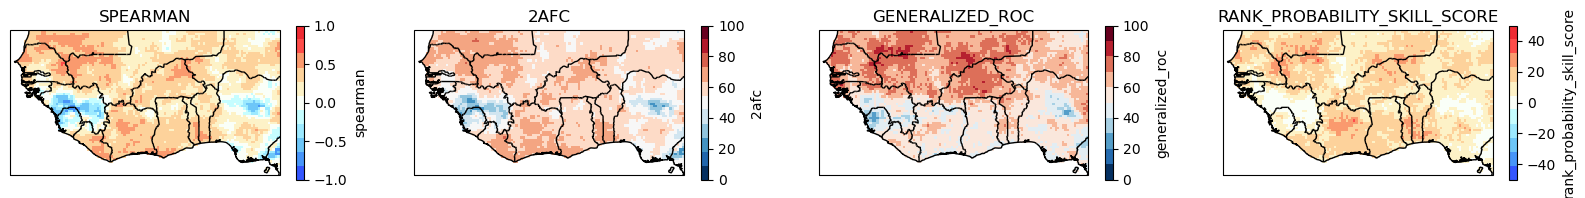

In [17]:
#skill_metrics = ['pearson', 'spearman', 'generalized_roc', 'rank_probability_skill_score']
# probabilistic metrics: 'generalized_roc', 'rank_probability_skill_score', 'ignorance'
# deterministic metrics: 16! incl 3 flavors of afc!
##cmaps = [plt.get_cmap('RdBu', 11), plt.get_cmap('RdBu', 11), plt.get_cmap('autumn_r', 10), plt.get_cmap('autumn_r', 11) ]
##limits = [(-1, 1), (-1, 1), (50, 100), (0, 50)]
# cmaps = [plt.get_cmap('cpt.correlation', 11), plt.get_cmap('cpt.correlation', 11), plt.get_cmap('RdBu_r', 10), plt.get_cmap('cpt.correlation', 11) ]
# limits = [(-1, 1), (-1, 1), (0, 100), (-50, 50)]

# my choices
skill_metrics = ['spearman','2afc', 'generalized_roc', 'rank_probability_skill_score']
cmaps = [plt.get_cmap('cpt.correlation', 11), plt.get_cmap('RdBu_r', 11), plt.get_cmap('RdBu_r', 10), plt.get_cmap('cpt.correlation', 11) ]
limits = [(-1,1), (0, 100), (0, 100), (-50, 50)]

cmaps[2].set_under('lightgray')
cmaps[3].set_under('lightgray')

## Do not modify below
# fig, ax = plt.subplots(nrows=len(skill_metrics), ncols=1, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(4, 5*len(skill_metrics)))
# for j, skill_metric in enumerate(skill_metrics):
#     ax[j].set_title(skill_metric)
#     getattr(nextgen_skill, skill_metric).where(getattr(nextgen_skill, skill_metric) > missing_value_flag).plot(ax=ax[j], cmap=cmaps[j], vmin=limits[j][0], vmax=limits[j][1])
#     ax[j].coastlines()
#     ax[j].add_feature(cartopyFeature.BORDERS)
    
# my plotting (taken from individual models, here with 1 row)
fig, ax = plt.subplots(nrows=1, ncols=len(skill_metrics), subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(5*len(skill_metrics), 1*len(predictor_names)))
if len(predictor_names) == 1: 
    ax = [ax]

for i in [1]:
    for j, skill_metric in enumerate(skill_metrics):
        ax[j].set_title(skill_metric)
        #n = getattr(skill[i], skill_metric).where(getattr(skill[i], skill_metric) > missing_value_flag).plot(ax=ax[i][j], cmap=cmaps[j], vmin=limits[j][0], vmax=limits[j][1])
        n = getattr(nextgen_skill, skill_metric).where(getattr(nextgen_skill, skill_metric) > missing_value_flag).plot(ax=ax[j], cmap=cmaps[j], vmin=limits[j][0], vmax=limits[j][1])

        ax[j].coastlines()
        ax[j].add_feature(cartopyFeature.BORDERS)
        ax[j].set_title(skill_metric.upper())

#    ax[i][0].text(-0.07, 0.55, model.upper(), va='bottom', ha='center', rotation='vertical', rotation_mode='anchor', transform=ax[i][0].transAxes)

# save plots
figName = MOS +'_ensemble_forecast_skillMatrices.png'
fig.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')   

#### Plot MME Forecasts

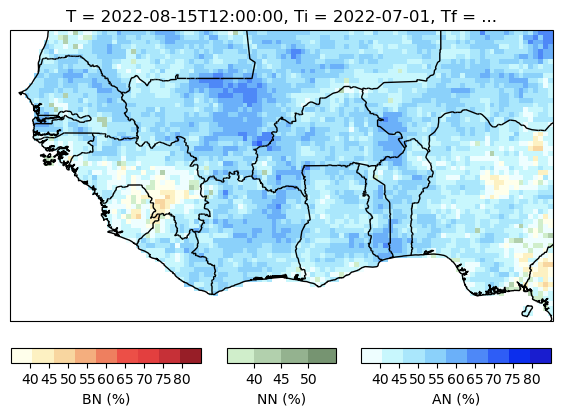

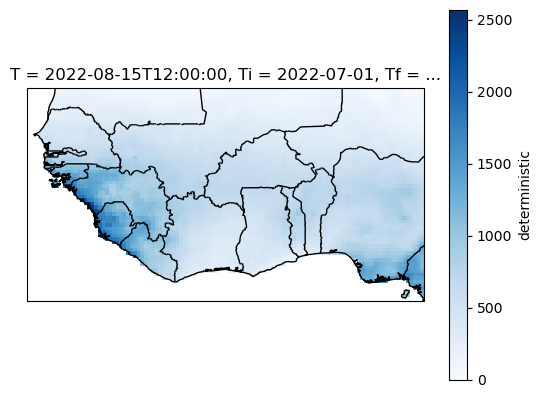

In [18]:
missing_value_flag = -999
prob_missing_value_flag = -1 

#ce.view_probabilistic(pr_fcst.where(pr_fcst > prob_missing_value_flag).rename({'C':'M'}).isel(T=-1) / 100)
matplotlibInstance, cartopyInstance = ce.view_probabilistic(pr_fcst.where(pr_fcst > prob_missing_value_flag).rename({'C':'M'}).isel(T=-1) / 100)
cartopyInstance.add_feature(cartopyFeature.BORDERS)

figName = MOS + '_ensemble_probabilisticForecast.png'
plt.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')

plt.show()
art = det_fcst.where(det_fcst > missing_value_flag).isel(T=-1).plot(subplot_kws={'projection': ccrs.PlateCarree()}, cmap='Blues', vmin=0)
# Anomlay:
#art = det_fcst.where(det_fcst > missing_value_flag).isel(T=-1).plot(subplot_kws={'projection': ccrs.PlateCarree()}, vmin=-100, vmax=100, cmap='RdBu')

art.axes.coastlines()
art.axes.add_feature(cartopyFeature.BORDERS)

figName = MOS + '_ensemble_deterministicForecast.png'
plt.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')

plt.show()

#### Construct MME Flexible Forecasts

In [19]:
# if 'isPercentile is True, the threshold is a percentile (e.g., 0.5)
# else in the unit of the predictand (e.g., mm, degC, ...)
threshold = 0.5
isPercentile = True

# choose a gridpoint within the predictand domain to plot the forecast and climatological
# probability of exceedance and PDF curves 
point_latitude = 7
point_longitude = 1

## DO NOT modify below
# Define transformer based on transform_predictand setting
if MOS =='CCA':
    if str(cpt_args['transform_predictand']).upper() == 'GAMMA':
        transformer = ce.GammaTransformer()
    elif str(cpt_args['transform_predictand']).upper() == 'EMPIRICAL':
        transformer = ce.EmpiricalTransformer()
    else:
        transformer = None
elif MOS == 'PCR':
    if str(cpt_args['transform_predictand']).upper() == 'GAMMA':
        transformer = ce.GammaTransformer()
    elif str(cpt_args['transform_predictand']).upper() == 'EMPIRICAL':
        transformer = ce.EmpiricalTransformer()
    else:
        transformer = None
else:
    print('FLEX FORECASTS NOT POSSIBLE WITHOUT MOS')

In [20]:
from scipy.stats import norm, t

# if the transformer is not none, then we used a y-transform in cpt
# therefore we have received a prediction error variance file in "units" of (standard normal deviates)^2
# and need to transform the forecast mean, in order to calculate probability of exceedance

if MOS in ['CCA', 'PCR']:
    if transformer is not None:
        # we need to normalize the forecast mean here, using the same method as CPT
        transformer.fit(Y.expand_dims({'M':[0]}))
        fcst_mu = transformer.transform(det_fcst.expand_dims({'M':[0]}))
    else:
        fcst_mu = det_fcst

    if isPercentile:
        if transformer is None:
            # if the user provided a percentile theshold, rather than an actual value
            # and also used no transformation / normalization, 
            # then we also need to compute the theshold as an actual value
            threshold = Y.quantile(threshold, dim='T').drop('quantile')
        else:
            # if the user used a transformation and gave a percentile threshold, 
            # we we can set the threshold using the cumulative distribution function 
            # for the normal distribution N(0, 1)- since thats what the Y data has 
            # been transformed to
            threshold = xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) * norm.cdf(threshold)
    else:
        if transformer is None:
            # if the user did not use a transform, and also did not use a percentile for a threshold,
            # we can just use the value directly. but it must be expanded to a 2D datatype
            threshold = xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) * threshold 
        else: 
            # if the user used a transformation, but gave a full value and NOT a percentile, 
            # we must use the transformation that CPT used to transform the threshold onto 
            # the normal distribution at N(0, 1)
            threshold = xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) * threshold 
            threshold = transformer.transform(threshold)
    
    def _xr_tsf(thrs, loc1, scale1, dof1=1):
        return t.sf(thrs, dof1, loc=loc1, scale=scale1)
    
    ntrain = Y.shape[list(Y.dims).index('T')]
    fcst_scale = np.sqrt( (ntrain -2)/ntrain * pev_fcst )
    
    # if we transformed the forecast data, we should transform the actual Y data to match
    if transformer is not None:
        Y2 = transformer.transform(Y.expand_dims({'M':[0]})).fillna(Y.min('T')) * xr.ones_like(Y.mean('T')).where(~np.isnan(Y.mean('T')), other=np.nan)
        Y2_fill = xr.where(~np.isfinite(Y2), 0, Y2)
        Y2 = xr.where(np.isfinite(Y2), Y2, Y2_fill)
    else:
        Y2 = Y
    # here we calculate the climatological mean and variance
    climo_var =  Y2.var('T') # xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) if transformer is not None else
    climo_mu =  Y2.mean('T') # xr.ones_like(fcst_mu).where(~np.isnan(fcst_mu), other=np.nan) if transformer is not None else
    climo_scale = np.sqrt( (ntrain -2)/ntrain * climo_var )
    
    # we calculate here, the probability of exceedance by taking 1 - t.cdf()
    # after having transformed the forecast mean to match the units of the 
    # prediction error variance, if necessary.
    exceedance_prob = xr.apply_ufunc( _xr_tsf, threshold, fcst_mu, fcst_scale, input_core_dims=[['X', 'Y'], ['X', 'Y'], ['X', 'Y']], output_core_dims=[['X', 'Y']],keep_attrs=True, kwargs={'dof1':ntrain})

/Users/andy/opt/anaconda3/envs/pycpt_environment/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


#### Plot Flexible MME Forecasts

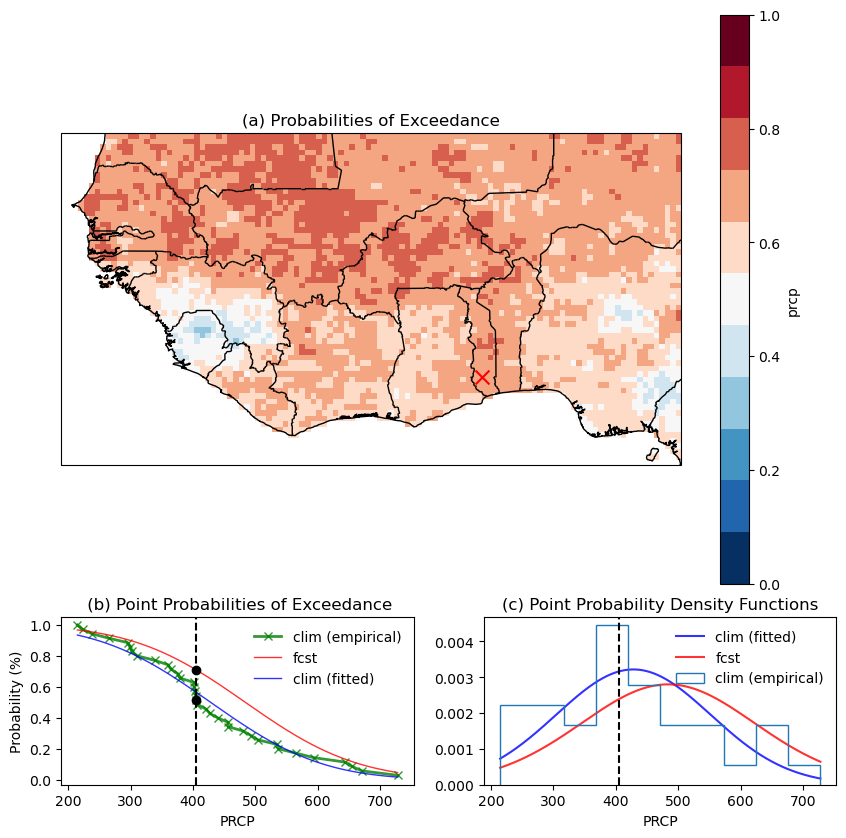

In [21]:
# plot exceedance probability map
cmap=plt.get_cmap('RdBu_r', 11)

# setting up canvas on which to draw
fig = plt.figure(figsize=(10,10))
gs0 = gridspec.GridSpec(4, 1, figure=fig)
gs00 = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=gs0[:3])
gs11 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[3])
gs01 = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=gs11[0])
gs02 = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=gs11[1])

map_ax = fig.add_subplot(gs00[:,:], projection = ccrs.PlateCarree())
cdf_ax = fig.add_subplot(gs01[:,:])     
pdf_ax = fig.add_subplot(gs02[:,:])     

# plot the map
art = exceedance_prob.transpose('Y', 'X', ...).plot(cmap=cmap,  ax=map_ax, vmin=0, vmax=1) 
map_ax.scatter([point_longitude], [point_latitude], marker='x', s=100, color='red', transform=ccrs.PlateCarree())
coasts = art.axes.coastlines()
art.axes.add_feature(cartopyFeature.BORDERS)
title = map_ax.set_title('(a) Probabilities of Exceedance')

# point calculations - select the nearest point to the lat/lon the user wanted to plot curves
point_threshold = float(threshold.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_fcst_scale = float(fcst_scale.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_climo_scale = float(climo_scale.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_fcst_mu = float(fcst_mu.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_climo_mu = float(climo_mu.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_climo = np.squeeze(Y2.sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
point_climo.sort()

if transformer is not None:
    point_climo_mu_nontransformed = float(Y.mean('T').sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)
    point_climo_std_nontransformed = float(Y.std('T').sel(**{'X':point_longitude, 'Y':point_latitude}, method='nearest').values)

x = point_climo 
x1 =np.linspace(x.min(), x.max(), 1000)
cprobth =  sum(x >= point_threshold) / x.shape[0]  #round(t.sf(point_threshold, ntrain, loc=point_climo_mu, scale=point_climo_scale),2)
fprobth = round(t.sf(point_threshold, ntrain, loc=point_fcst_mu, scale=point_fcst_scale),2)

# POE plot
cdf_ax.plot(x, [ sum(x >= x[i]) / x.shape[0] for i in range(x.shape[0]) ],'g-', lw=2, marker='x', alpha=0.8, label='clim (empirical)')
cdf_ax.plot(x1, t.sf(x1, ntrain, loc=point_fcst_mu, scale=point_fcst_scale),'r-',  lw=1, alpha=0.8, label='fcst')
cdf_ax.plot(x1, norm.sf(x1, loc=point_climo_mu, scale=point_fcst_scale),'b-', lw=1, alpha=0.8, label='clim (fitted)')

cdf_ax.plot(point_threshold, fprobth,'ok')
cdf_ax.plot(point_threshold, cprobth,'ok')
cdf_ax.axvline(x=point_threshold, color='k', linestyle='--')
cdf_ax.set_title(' (b) Point Probabilities of Exceedance')
cdf_ax.set_xlabel(Y.name.upper())
cdf_ax.set_ylabel('Probability (%)')
cdf_ax.legend(loc='best', frameon=False)

# PDF plot
#fpdf=t.pdf(x1, ntrain, loc=point_fcst_mu, scale=np.sqrt(point_fcst_scale))
fpdf=t.pdf(x1, ntrain, loc=point_fcst_mu, scale=point_fcst_scale)

pdf_ax.plot(x1, norm.pdf(x1, loc=point_climo_mu, scale =point_climo_scale), 'b-', alpha=0.8, label='clim (fitted)') # clim pdf in blue
pdf_ax.plot(x1, fpdf, 'r-',  alpha=0.8, label='fcst') # fcst PDF in red
pdf_ax.hist(point_climo, density=True, histtype='step', label='clim (empirical)') # want this in GREEN

pdf_ax.axvline(x=point_threshold, color='k', linestyle='--')
pdf_ax.legend(loc='best', frameon=False)
pdf_ax.set_title('(c) Point Probability Density Functions')
pdf_ax.set_xlabel(Y.name.upper())
pdf_ax.set_ylabel('')

if transformer is not None:
    newticks = [-2, -1, 0, 1, 2]
    pdf_ax.set_xticks(newticks, [round(i * point_climo_std_nontransformed + point_climo_mu_nontransformed, 2) for i in newticks], rotation=0)
    cdf_ax.set_xticks(newticks, [round(i * point_climo_std_nontransformed + point_climo_mu_nontransformed, 2) for i in newticks], rotation=0)

# save plot
figName = MOS +'_flexForecast_probExceedence.png'
plt.savefig(Path.home() / "Desktop" / caseDir / domainFolder / "figures" / figName, bbox_inches='tight')